In [35]:
#Loading data and image plotting
import json
import cv2
import matplotlib.pyplot as plt
import os
from pathlib import Path

#NN
import keras
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

#Utility
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
#Used for mounting data from drive to GColab - leave out when running locally
from google.colab import drive
container_folder_abspath = Path('/content/myfiles')
gdrive_subfolder_relpath = Path('MyDrive/MVI/semestral_work')
drive.mount(str(container_folder_abspath))

this_file = "models/autoencoders/basic_autoencoder"
fullpath = container_folder_abspath / gdrive_subfolder_relpath / "mvi-sp" / this_file # Path objects with the operator /
%cd $fullpath
!pwd

Mounted at /content/myfiles
/content/myfiles/MyDrive/MVI/semestral_work/mvi-sp/models/autoencoders/basic_autoencoder
/content/myfiles/MyDrive/MVI/semestral_work/mvi-sp/models/autoencoders/basic_autoencoder


In [4]:
#Data preparation
with open('../../../data/cards_border1997.json', 'r') as f:
    cards_b1997_data = json.load(f)
with open('../../../data/cards_border2003.json', 'r') as f:
    cards_b2003_data = json.load(f)
with open('../../../data/cards_border2015.json', 'r') as f:
    cards_b2015_data = json.load(f)

In [40]:
cards_datasets = [cards_b2003_data]
cards_folders = ['art_border2003']
data = zip(cards_datasets,cards_folders)

images = []
card_metadata = []

for dataset,folder in data:
    print('Dataset folder: {}'.format(folder))
    for i,card in enumerate(dataset):
        img = cv2.imread('../../../data/preprocessed/136x100/{}.jpg'.format(card['id']))
        if img is None:
          print('{} not found.'.format(card['id']))
        else :
          images.append(img)
          card_metadata.append(card)
        if i % 500 == 0 and i != 0 :
            print('{} artworks loaded'.format(i))

Dataset folder: art_border2003
500 artworks loaded
1000 artworks loaded
1500 artworks loaded
2000 artworks loaded
2500 artworks loaded
3000 artworks loaded
3500 artworks loaded
4000 artworks loaded
4500 artworks loaded


In [41]:
print(len(images))
print(images[0].shape)
print(len(card_metadata))

4836
(100, 136, 3)
4836


In [42]:
experiment_name = 'testing_experiment1'

input_size = images[0].shape[0]*images[0].shape[1]*images[0].shape[2]

x_images = np.array(images)
x_images = x_images.reshape((len(images), input_size))

x_train,x_test,card_metadata_train, card_metadata_test = train_test_split(x_images,card_metadata,test_size=0.20,shuffle=False)
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [43]:
# This is the size of our encoded representations
encoding_dim = 200

input_img = keras.Input(shape=(input_size,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
decoded = layers.Dense(input_size, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

In [44]:
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [45]:
autoencoder.compile(optimizer='adam', loss='mse')


In [46]:
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 40800)]           0         
                                                                 
 dense_2 (Dense)             (None, 200)               8160200   
                                                                 
 dense_3 (Dense)             (None, 40800)             8200800   
                                                                 
Total params: 16,361,000
Trainable params: 16,361,000
Non-trainable params: 0
_________________________________________________________________


In [57]:
from math import ceil
earlyStop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

batch_size = 256
save_every_n_epoch = 20
model_checkpoint_callback = ModelCheckpoint(
    filepath="/model-checkpoints/{}".format(experiment_name)+"/prelim_{epoch:02d}",
    monitor="val_loss",
    save_freq=ceil(x_train.shape[0]/batch_size)*save_every_n_epoch)


In [58]:
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=False,
                validation_data=(x_test, x_test),
                callbacks=[earlyStop,model_checkpoint_callback])



Epoch 1/100
16/16 [==============================] - 10s 636ms/step - loss: 0.0388 - val_loss: 0.0393
Epoch 2/100
16/16 [==============================] - 10s 626ms/step - loss: 0.0378 - val_loss: 0.0383
Epoch 3/100
16/16 [==============================] - 10s 606ms/step - loss: 0.0370 - val_loss: 0.0378
Epoch 4/100
16/16 [==============================] - 10s 636ms/step - loss: 0.0364 - val_loss: 0.0374
Epoch 5/100
16/16 [==============================] - 10s 626ms/step - loss: 0.0356 - val_loss: 0.0367
Epoch 6/100
16/16 [==============================] - 11s 716ms/step - loss: 0.0350 - val_loss: 0.0366
Epoch 7/100
16/16 [==============================] - 10s 619ms/step - loss: 0.0349 - val_loss: 0.0373
Epoch 8/100
16/16 [==============================] - 10s 614ms/step - loss: 0.0339 - val_loss: 0.0360
Epoch 9/100
16/16 [==============================] - 10s 637ms/step - loss: 0.0333 - val_loss: 0.0359
Epoch 10/100
16/16 [==============================] - 10s 635ms/step - loss: 0.032

In [59]:
#Save final model
autoencoder.save("/model-checkpoints/{}".format(experiment_name)+"/final")

INFO:tensorflow:Assets written to: /checkpoints/testing_experiment1/final/assets


In [60]:
encoded_imgs_test = encoder.predict(x_test)
decoded_imgs_test = decoder.predict(encoded_imgs_test)

encoded_imgs_train = encoder.predict(x_train)
decoded_imgs_train = decoder.predict(encoded_imgs_train)

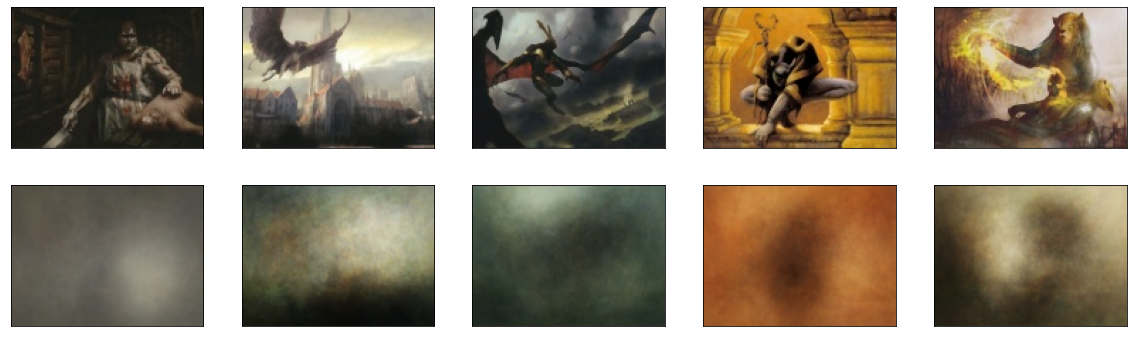

In [61]:
n = 5  # How many images we will display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cv2.cvtColor(x_train[i].reshape(100, 136,3), cv2.COLOR_BGR2RGB))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cv2.cvtColor(decoded_imgs_train[i].reshape(100, 136,3), cv2.COLOR_BGR2RGB))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

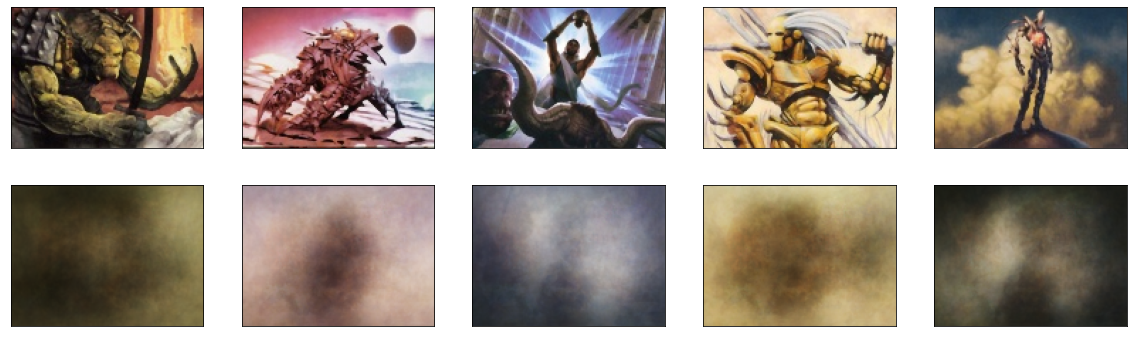

In [62]:
n = 5  # How many digits we will display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cv2.cvtColor(x_test[i].reshape(100, 136,3), cv2.COLOR_BGR2RGB))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cv2.cvtColor(decoded_imgs_test[i].reshape(100, 136,3), cv2.COLOR_BGR2RGB))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [63]:
 #Save results
save_folder = '../../../model_results/autoencoders/basic_autoencoder/testing_experiment1/'
if not os.path.isdir(save_folder):
    print('Directory created')
    os.makedirs(save_folder)

for original_img,c_metadata,reconstructed_img in list(zip(x_test,card_metadata_test,decoded_imgs_test))[:10]:
    cv2.imwrite('{}/{}_orig.png'.format(save_folder,c_metadata['id']), (original_img*255.).reshape(100, 136,3))
    cv2.imwrite('{}/{}_reconstructed.png'.format(save_folder,c_metadata['id']), (reconstructed_img*255.).reshape(100, 136,3))